## VAE sur MNIST

Théo NGUYEN

Ce devoir provient en grande partie du cours atiam_ml - 11a_GAN et 10_VAE

## Handwritten digits generator

In this example, we are going to define a VAE to generate images of handwritten digits. For that, we will train the models using the infamous MNIST dataset. 

Again, we are going to make use of `torch` and `torchvision` . Notably, we will use `transforms` to obtain the training data and perform image conversions.

In [21]:
import numpy as np
import math
import random as rd
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
hdr_plot_style()

import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.distributions as distrib

import os
import seaborn as sns


Since this example uses images in the training set, the models need to be more complex, with a larger number of parameters. This makes the training process slower, taking about two minutes per epoch when running on CPU. To reduce the training time, you can use a GPU to train the model if you have one available. The following piece of code allows to automatically select the best device available on your system.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Preparing the training data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to convert them to Tensors. Also, in order to ensure adequate learning, it is always best to normalize the data. This is were we make use of `torchvision.transforms` in order to perfom thesse automatically while loading the data.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

Now, as usual, we can load both the *training* and *testing* data with the datasets objects

In [5]:
batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Here we plot some examples of the train set, to better understand the underlying data that we are working with.

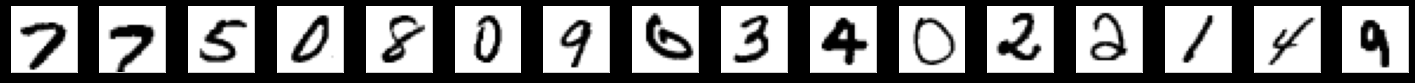

In [44]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout() 

<a id="implem"> </a>

## VAE implementation

As we have seen, VAEs can be simply implemented by decomposing the above series of operations into an `encoder` which represents the distribution $q_\phi(\mathbf{z}\vert\mathbf{x})$, from which we will sample some values $\tilde{\mathbf{z}}$ (using the reparametrization trick) and compute the Kullback-Leibler (KL) divergence. Then, we use these values as input to a `decoder` which represents the distribution $p_\theta(\mathbf{x}\vert\mathbf{z})$ so that we can produce a reconstruction $\tilde{\mathbf{x}}$ and compute the reconstruction error. 

Therefore, we can define the VAE based on our previous implementation of the AE that we recall here

In [7]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In order to move to a probabilistic version, we need to add the latent space sampling mechanism, and change the behavior of our `call` function. This process is implemented in the following `VAE` class.

Note that we purposedly rely on an implementation of the `encode` function where the `encoder` first produces an intermediate representation of size `encoder_dims`. Then, this representation goes through two separate functions for encoding $\mathbf{\mu}$ and $\mathbf{\sigma}$. This provides a clearer implementation but also the added bonus that we can ensure that $\mathbf{\sigma} > 0$

In [8]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)

        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        
        mu, sigma = z_params
        
        var = sigma * sigma
        log_var = torch.log(var)
        
        z = torch.randn_like(mu) * sigma + mu        
        kl_div = (1/2) * (mu * mu + var - log_var - 1).sum()
        
        return z, kl_div

Now the interesting aspect of VAEs is that we can define any parametric function as `encoder` and `decoder`, as long as we can optimize them. Here, we will rely on simple feed-forward neural networks, but these can be largely more complex (with limitations that we will discuss later in the tutorial).

In [65]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):

#     # Encoder network

      encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nin, n_hidden), nn.ReLU(),
            nn.Linear(n_hidden, n_hidden), nn.ReLU(),
            nn.Linear(n_hidden, n_hidden), nn.ReLU(),
      )

      # encoder = nn.Sequential(
      #       nn.Conv2d(1, 3, (3,3), padding=1),
      #       nn.ReLU(),
      #       nn.Conv2d(3, 16, (3,3), padding=1),
      #       nn.ReLU(),
      #       nn.Conv2d(16, 32, (3,3), padding=1),
      #       nn.ReLU(),
      #       )   

    # Decoder network

      decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
      )
      
      # decoder = nn.Sequential(
      #       nn.ConvTranspose2d(32, 16, (3,3), padding=1),
      #       nn.ReLU(),
      #       nn.ConvTranspose2d(16, 3, (3,3), padding=1),
      #       nn.ReLU(),
      #       nn.ConvTranspose2d(3, 1, (3,3), padding=1),
      #       nn.ReLU(),
      #       ) 

      return encoder, decoder

### Evaluating the error

In the definition of the `VAE` class, we directly included the computation of the $D_{KL}$ term to regularize our latent space. However, remember that the complete loss of equation (4) also contains a *reconstruction loss* which compares our reconstructed output to the original data. 

While there are several options to compare the error between two elements, there are usually two preferred choices among the generative literature depending on how we consider our problem
1. If we consider each dimension (pixel) to be a binary unit (following a Bernoulli distribution), we can rely on the `binary cross entropy` between the two distributions
2. If we turn our problem to a set of classifications, where each dimension can belong to a given set of *intensity classes*, then we can compute the `multinomial loss` between the two distributions

In the following, we define both error functions and regroup them in the `reconstruction_loss` call (depending on the `num_classes` considered). However, as the `multinomial loss` requires a large computational overhead, and for the sake of simplicity, we will train all our first models by relying on the `binary cross entropy`

In [66]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='sum')

def compute_loss(model, x):
        
    beta = 0.1
    x_rec, kl_div = model(x)
    
    recons_loss = recons_criterion(x_rec, x)
    full_loss = recons_loss + kl_div * beta
    
    return full_loss

def train_step(model, x, optimizer):

    # Compute the loss.
    loss = compute_loss(model, x)

    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()

    # Calling the step function to update the parameters
    optimizer.step()
    
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [67]:
imgs_test, labels = next(iter(train_loader))

# Using Bernoulli or Multinomial loss
num_classes = 1

# Number of hidden and latent
n_hidden = 512
n_latent = 2

# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]

# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)

# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)

# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

Epoch: 1, Test set: tensor([42707212.], grad_fn=<AddBackward0>)


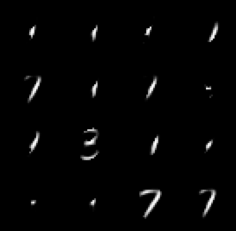

Epoch: 2, Test set: tensor([42688824.], grad_fn=<AddBackward0>)


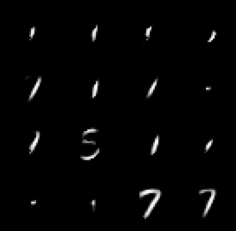

Epoch: 3, Test set: tensor([42671220.], grad_fn=<AddBackward0>)


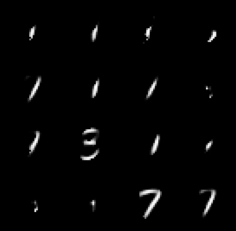

Epoch: 4, Test set: tensor([42667668.], grad_fn=<AddBackward0>)


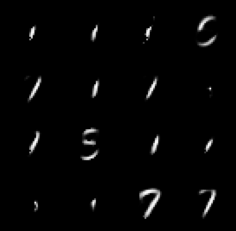

Epoch: 5, Test set: tensor([42667488.], grad_fn=<AddBackward0>)


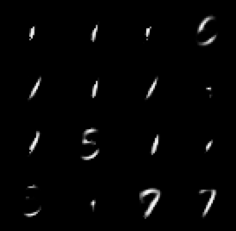

Epoch: 6, Test set: tensor([42653376.], grad_fn=<AddBackward0>)


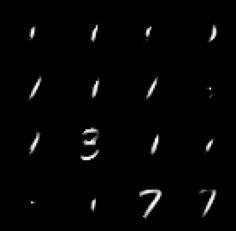

Epoch: 7, Test set: tensor([42642428.], grad_fn=<AddBackward0>)


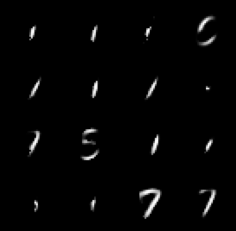

Epoch: 8, Test set: tensor([42628356.], grad_fn=<AddBackward0>)


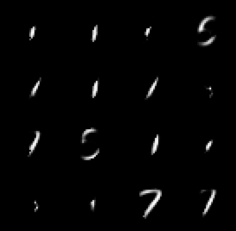

Epoch: 9, Test set: tensor([42616420.], grad_fn=<AddBackward0>)


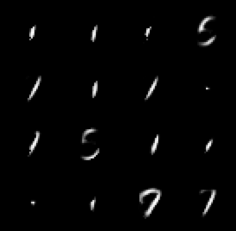

Epoch: 10, Test set: tensor([42630516.], grad_fn=<AddBackward0>)


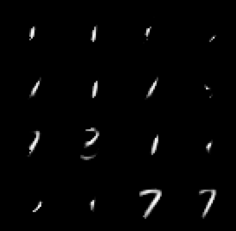

Epoch: 11, Test set: tensor([42626744.], grad_fn=<AddBackward0>)


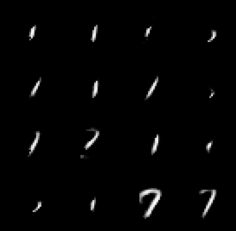

Epoch: 12, Test set: tensor([42605520.], grad_fn=<AddBackward0>)


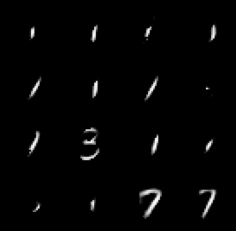

Epoch: 13, Test set: tensor([42592208.], grad_fn=<AddBackward0>)


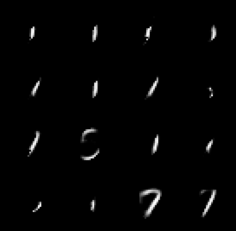

Epoch: 14, Test set: tensor([42579068.], grad_fn=<AddBackward0>)


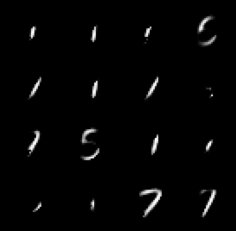

Epoch: 15, Test set: tensor([42562824.], grad_fn=<AddBackward0>)


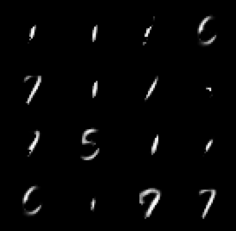

Epoch: 16, Test set: tensor([42555616.], grad_fn=<AddBackward0>)


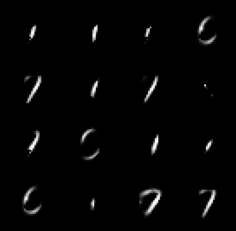

Epoch: 17, Test set: tensor([42545932.], grad_fn=<AddBackward0>)


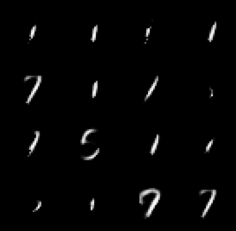

Epoch: 18, Test set: tensor([42557352.], grad_fn=<AddBackward0>)


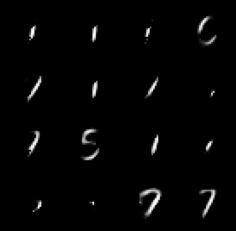

Epoch: 19, Test set: tensor([42537920.], grad_fn=<AddBackward0>)


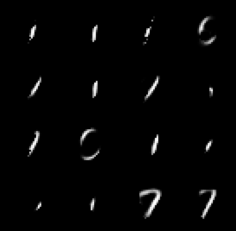

Epoch: 20, Test set: tensor([42533340.], grad_fn=<AddBackward0>)


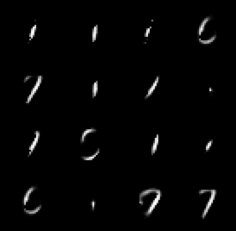

Epoch: 21, Test set: tensor([42522364.], grad_fn=<AddBackward0>)


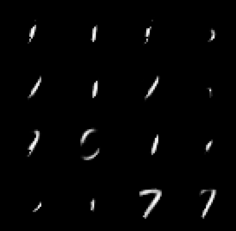

Epoch: 22, Test set: tensor([42522200.], grad_fn=<AddBackward0>)


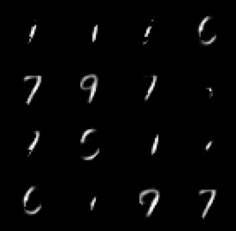

Epoch: 23, Test set: tensor([42498744.], grad_fn=<AddBackward0>)


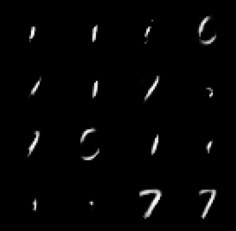

Epoch: 24, Test set: tensor([42495892.], grad_fn=<AddBackward0>)


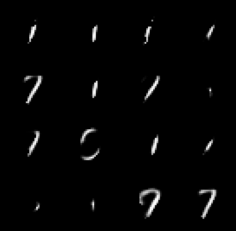

Epoch: 25, Test set: tensor([42497860.], grad_fn=<AddBackward0>)


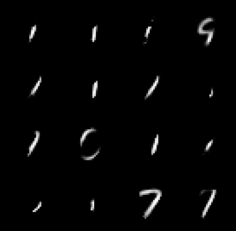

Epoch: 26, Test set: tensor([42493920.], grad_fn=<AddBackward0>)


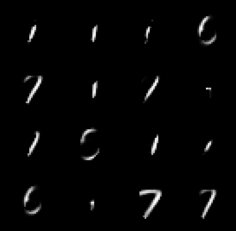

Epoch: 27, Test set: tensor([42479868.], grad_fn=<AddBackward0>)


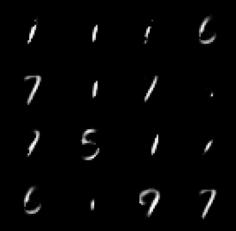

Epoch: 28, Test set: tensor([42470696.], grad_fn=<AddBackward0>)


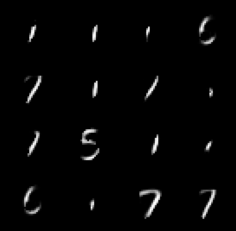

Epoch: 29, Test set: tensor([42479064.], grad_fn=<AddBackward0>)


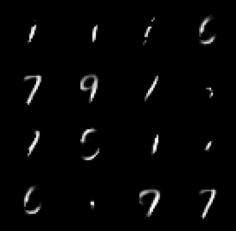

Epoch: 30, Test set: tensor([42456628.], grad_fn=<AddBackward0>)


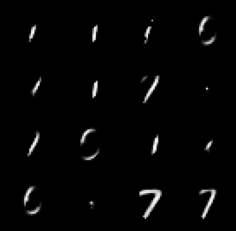

Epoch: 31, Test set: tensor([42454144.], grad_fn=<AddBackward0>)


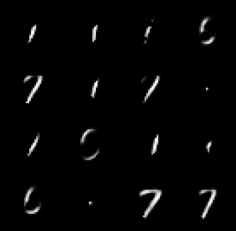

Epoch: 32, Test set: tensor([42453572.], grad_fn=<AddBackward0>)


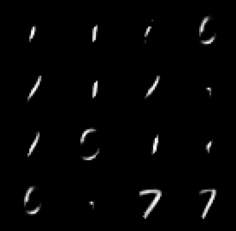

Epoch: 33, Test set: tensor([42449424.], grad_fn=<AddBackward0>)


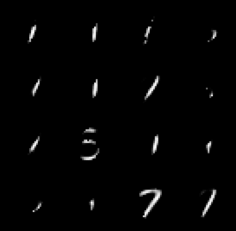

Epoch: 34, Test set: tensor([42461796.], grad_fn=<AddBackward0>)


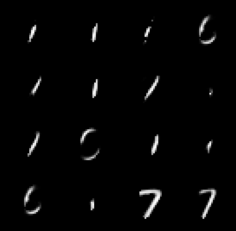

Epoch: 35, Test set: tensor([42440028.], grad_fn=<AddBackward0>)


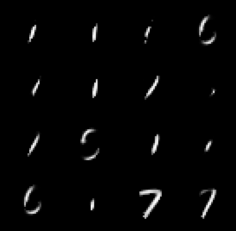

Epoch: 36, Test set: tensor([42431648.], grad_fn=<AddBackward0>)


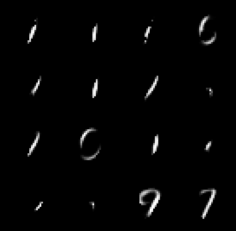

Epoch: 37, Test set: tensor([42421768.], grad_fn=<AddBackward0>)


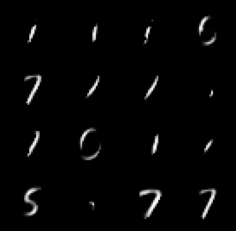

Epoch: 38, Test set: tensor([42422592.], grad_fn=<AddBackward0>)


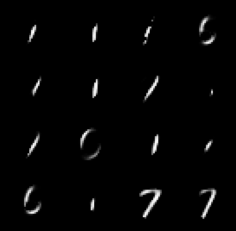

Epoch: 39, Test set: tensor([42420176.], grad_fn=<AddBackward0>)


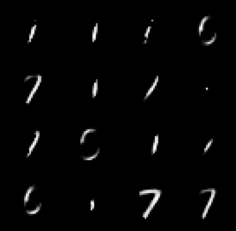

Epoch: 40, Test set: tensor([42414204.], grad_fn=<AddBackward0>)


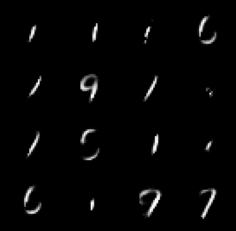

Epoch: 41, Test set: tensor([42411324.], grad_fn=<AddBackward0>)


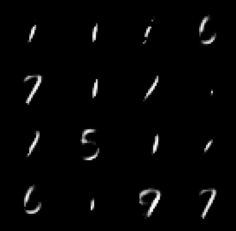

Epoch: 42, Test set: tensor([42431208.], grad_fn=<AddBackward0>)


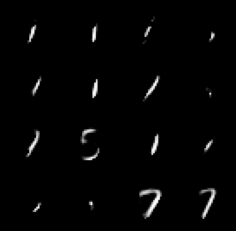

Epoch: 43, Test set: tensor([42410512.], grad_fn=<AddBackward0>)


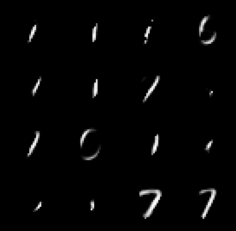

Epoch: 44, Test set: tensor([42393920.], grad_fn=<AddBackward0>)


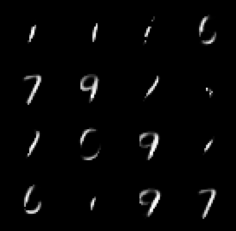

Epoch: 45, Test set: tensor([42408576.], grad_fn=<AddBackward0>)


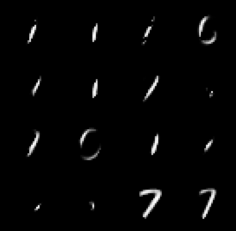

Epoch: 46, Test set: tensor([42402712.], grad_fn=<AddBackward0>)


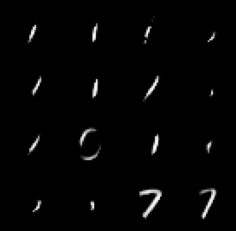

Epoch: 47, Test set: tensor([42405288.], grad_fn=<AddBackward0>)


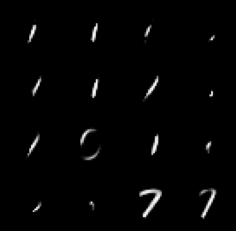

Epoch: 48, Test set: tensor([42379348.], grad_fn=<AddBackward0>)


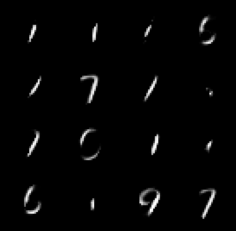

Epoch: 49, Test set: tensor([42378780.], grad_fn=<AddBackward0>)


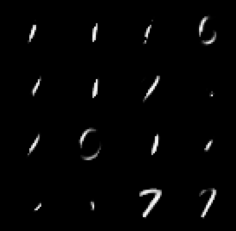

Epoch: 50, Test set: tensor([42375044.], grad_fn=<AddBackward0>)


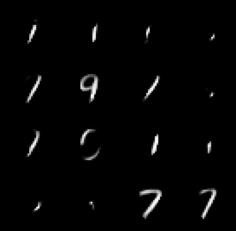

In [70]:
def generate_and_save_images(model, epoch, test_sample):

    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    
    plt.show()
learn = False
if learn:

    epochs=50
    test_sample = imgs_test[0:16, :, :, :]

    for epoch in range(1, epochs + 1):

        full_loss = torch.Tensor([0])

        # Forward pass: compute predicted y by passing x to the model.
        for i, (x, _) in enumerate(train_loader):
            # Compute the loss
            loss, kl_div = compute_loss(model, x, beta=1e-4)

            # Before the backward pass, zero all of the network gradients
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to parameters
            loss.backward()
            
            # Calling the step function to update the parameters
            optimizer.step()
            full_loss += loss    
        
        #TO CHECK THE LEARNING    
        #for i, (x, _) in enumerate(valid_loader):
        #    train_step(model, x, optimizer)

        print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
        print(f"KL {kl_div}")
        generate_and_save_images(model, epoch, test_sample)

    #SAVING...
    PATH = "VAE_MNIST_model"
    #torch.save(model.state_dict(), PATH)
    torch.save(model, PATH)

else :
    model = torch.load("VAE_MNIST_model")
    

In [71]:
PATH = "VAE_MNIST_model"
#torch.save(model.state_dict(), PATH)
torch.save(model, PATH)
